# Part 1

In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np

# Get the data 
df = pd.read_csv("football.csv", sep=";")
df_test = df[df.isna().any(axis=1)]
df = df.dropna()
display(df.columns)

X = df.drop(columns="GoalsScored")
scaler = StandardScaler()
X = scaler.fit_transform(X)
X = np.hstack([np.ones((X.shape[0], 1)), X]) # ADD INTERCEPT
y = df["GoalsScored"]

Index(['X_ScoreRateH', 'X_ScoreRateA', 'X_ConcedeRateH', 'X_ConcedeRateA',
       'X_CornerRatioH', 'X_CornerRatioA', 'X_FoulRatioH', 'X_FoulRatioA',
       'GoalsScored'],
      dtype='object')

In [2]:
import pymc as pm

alpha = 10

# Modeling 
with pm.Model() as model:
    beta = pm.Normal("beta", mu = 0, sigma = alpha, shape = X.shape[1])

    # Link function
    mu = pm.math.exp(pm.math.dot(X, beta))

    y_obs = pm.Poisson("y_obs", mu=mu, observed = y)

    trace = pm.sample(1000,chains = 4, tune=1000, return_inferencedata=True)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.


### Density plot

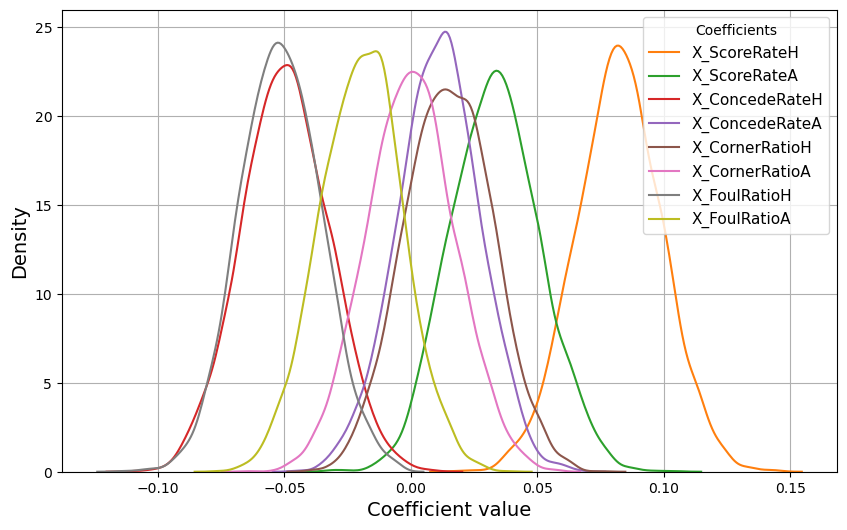

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
import arviz as az

# Extract posterior samples for beta (excluding intercept, assuming last is intercept)
betas = trace.posterior["beta"].stack(draws=("chain", "draw")).values  # shape: (n_betas, n_samples)

plt.figure(figsize=(10, 6))
palette = sns.color_palette("tab10", betas.shape[0])

labels = ["X_ScoreRateH","X_ScoreRateA","X_ConcedeRateH","X_ConcedeRateA","X_CornerRatioH","X_CornerRatioA","X_FoulRatioH","X_FoulRatioA"]

for i in range(1,betas.shape[0]):
    sns.kdeplot(betas[i], label=labels[i - 1], color=palette[i])

plt.xlabel('Coefficient value', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.legend(title='Coefficients', fontsize=11)
plt.grid(True)
plt.savefig("report/figures/densities.png")


### Trace plot

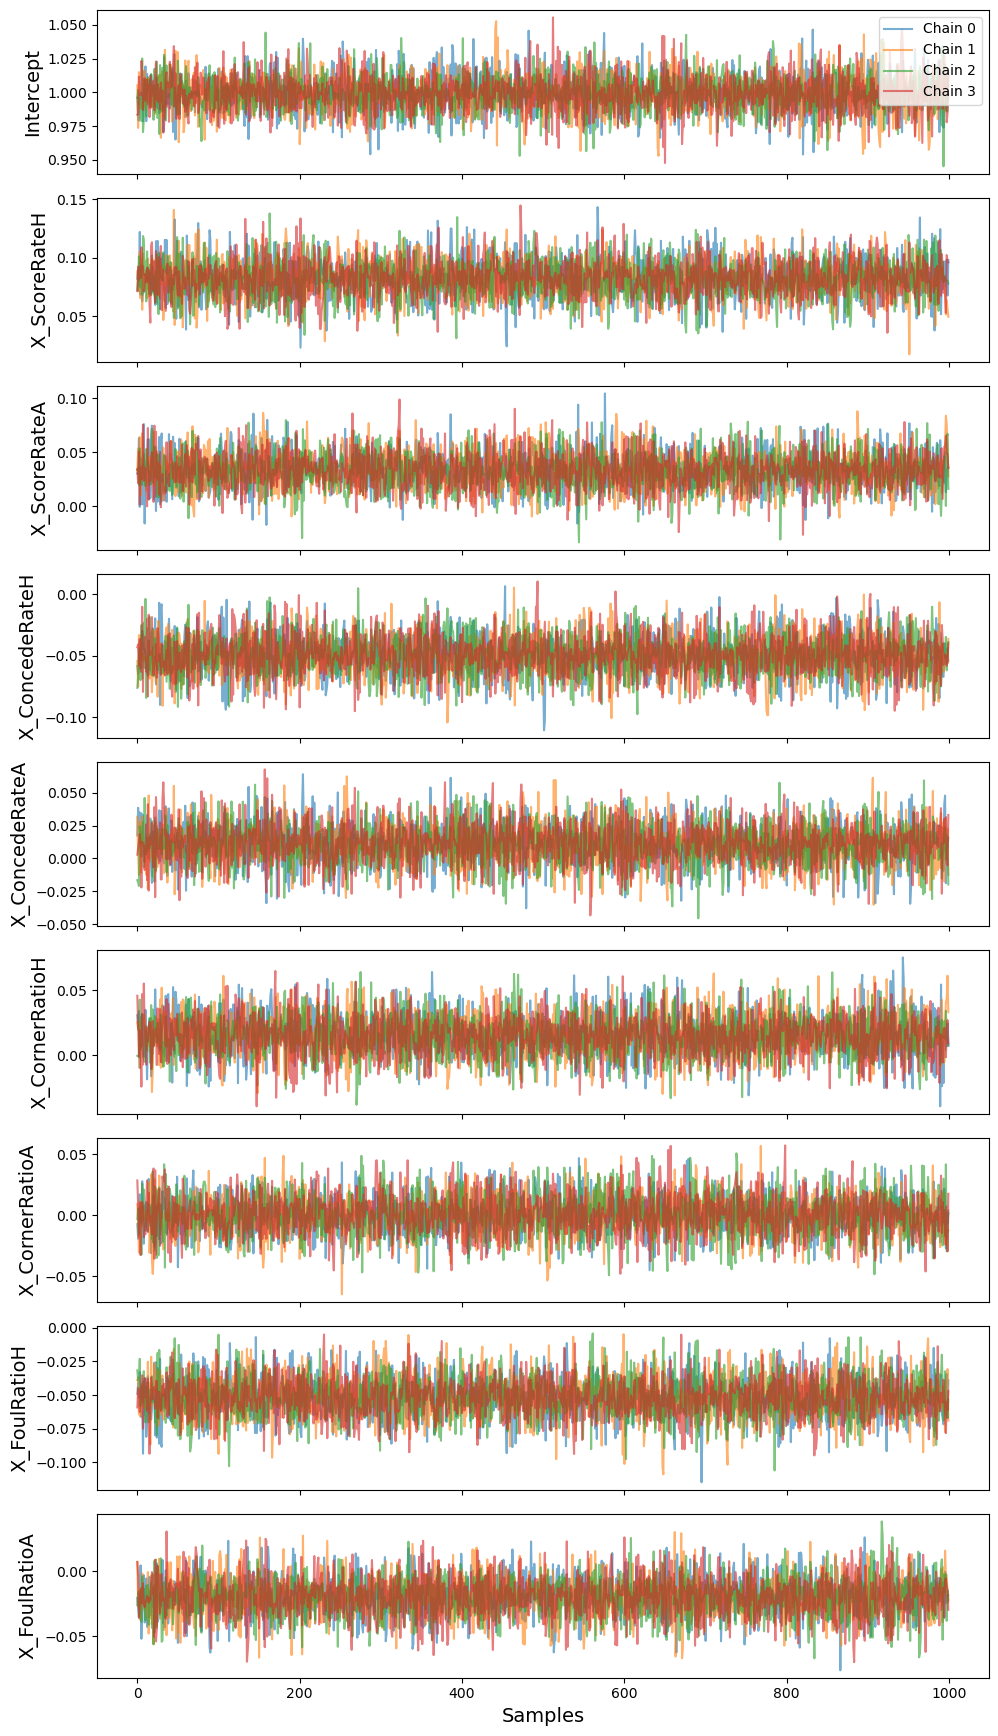

In [4]:
import matplotlib.pyplot as plt

samples = trace.posterior["beta"].values  # shape: (n_chains, n_draws, n_betas)
n_chains, n_draws, n_betas = samples.shape

fig, axes = plt.subplots(n_betas, 1, figsize=(10, 2 * n_betas), sharex=True)

if n_betas == 1:
    axes = [axes]

labels = ["Intercept", "X_ScoreRateH", "X_ScoreRateA", "X_ConcedeRateH", "X_ConcedeRateA",
          "X_CornerRatioH", "X_CornerRatioA", "X_FoulRatioH", "X_FoulRatioA"]

colors = plt.cm.tab10.colors  # up to 10 distinct colors

for i in range(n_betas):
    ax = axes[i]
    for chain in range(n_chains):
        ax.plot(samples[chain, :, i], alpha=0.6, color=colors[chain % len(colors)], label=f"Chain {chain}" if i == 0 else "")
    ax.set_ylabel(labels[i], fontsize=14)

axes[-1].set_xlabel('Samples', fontsize=14)
axes[0].legend(loc='upper right')  # Show legend once

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.savefig("report/figures/trace.png")

### Autocorrelation

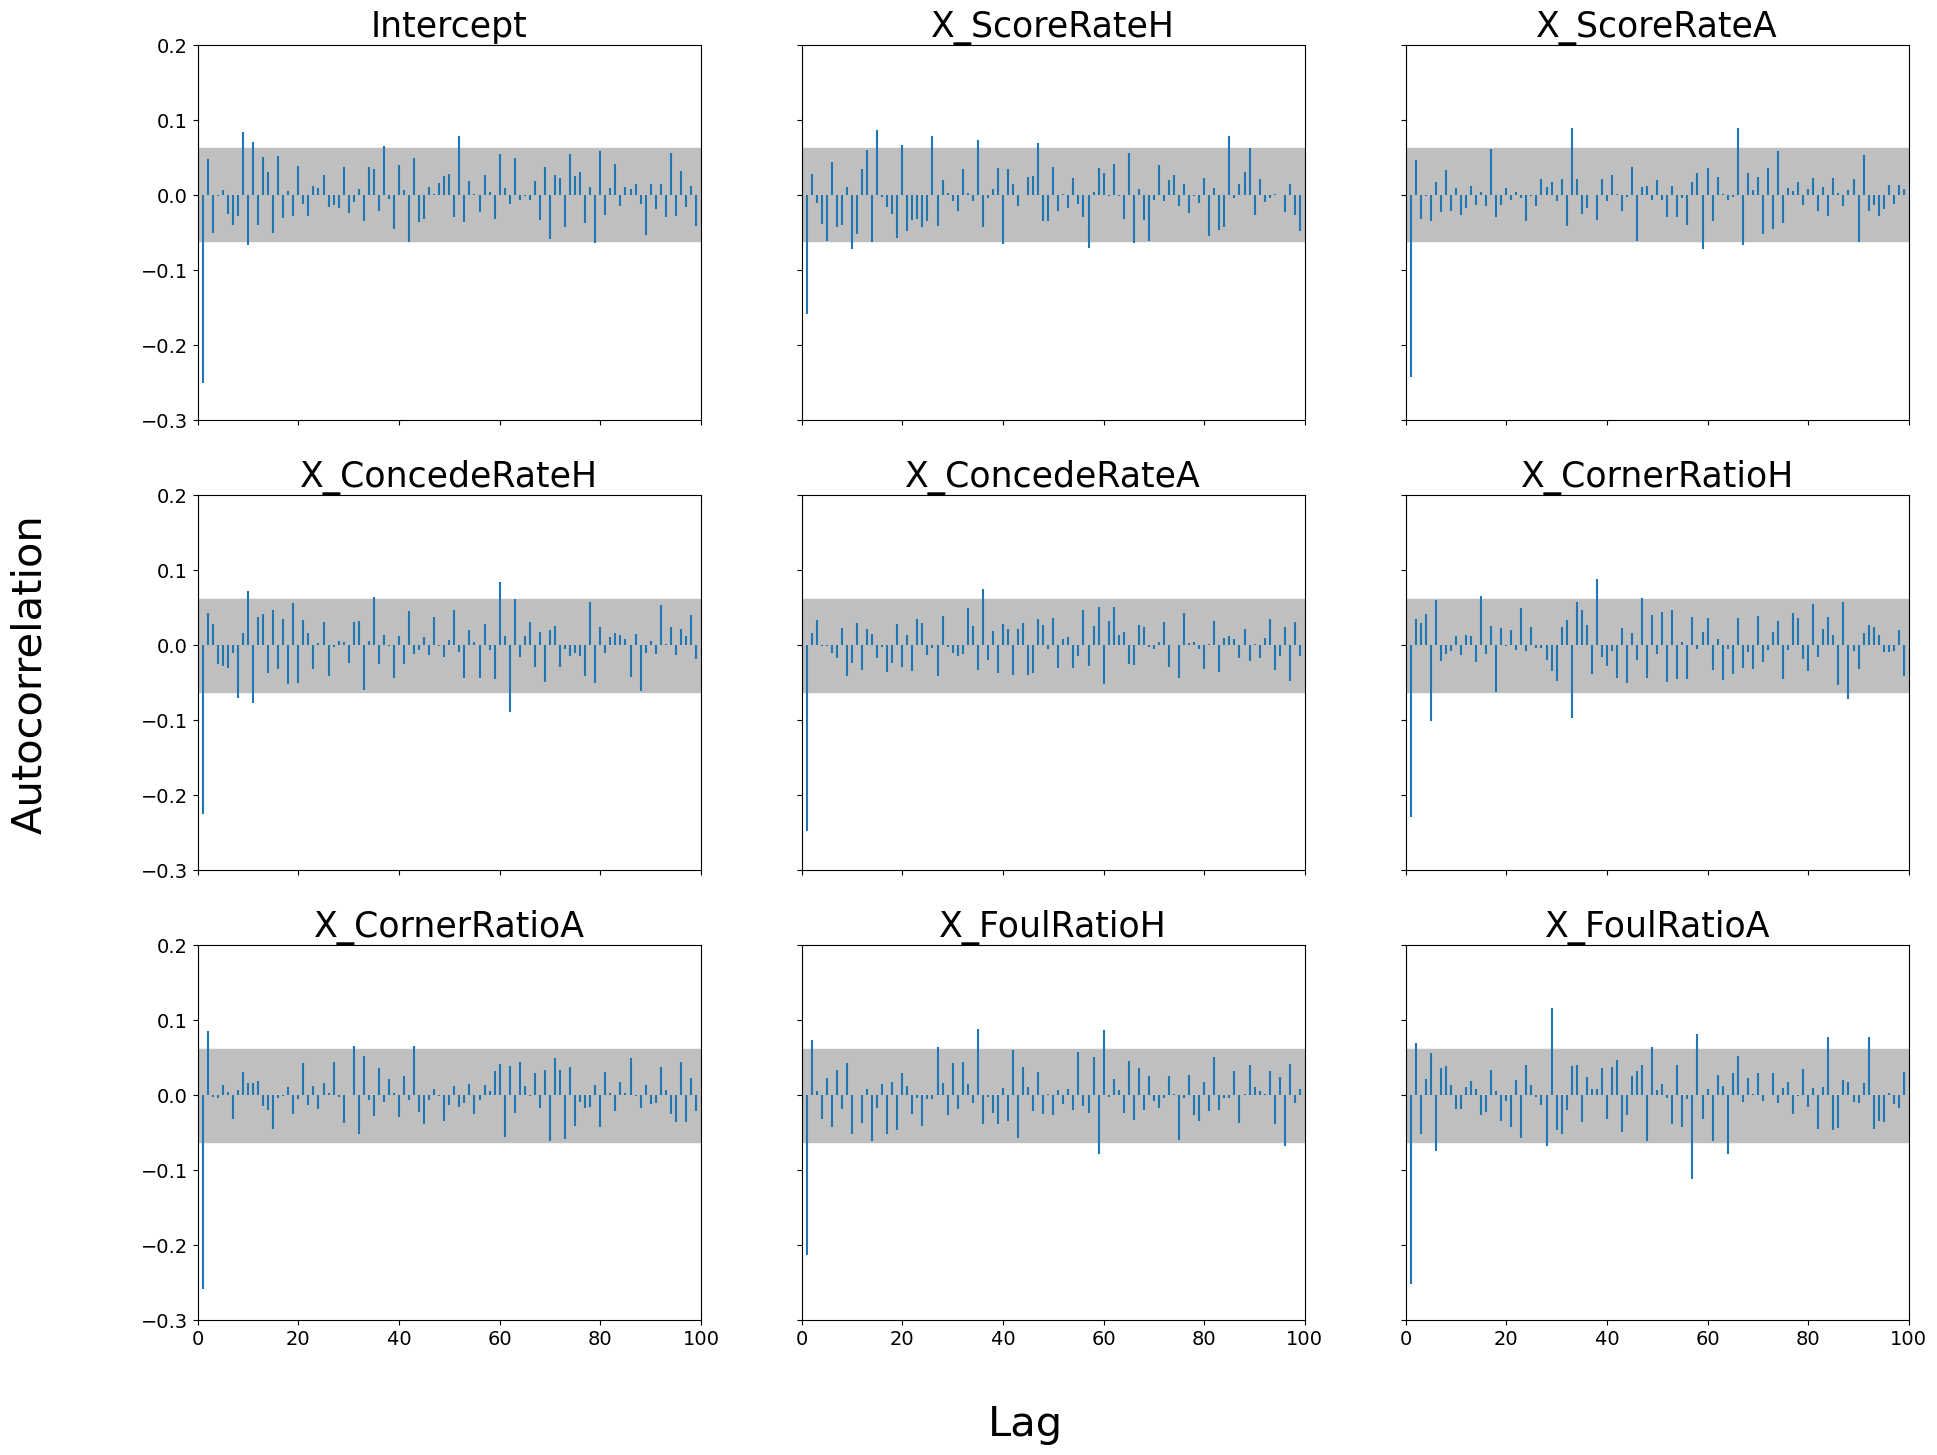

In [5]:
trace_chain0 = trace.sel(chain=0)

axes = az.plot_autocorr(trace_chain0, var_names=["beta"])

for i, ax in enumerate(axes.flatten()):
    ax.set_ylim(-0.3, 0.2)
    ax.set_title(labels[i], fontsize=25)


fig = axes.flatten()[0].figure
fig.text(0.5, 0.04, 'Lag', ha='center', fontsize=30)
fig.text(0.04, 0.5, 'Autocorrelation', va='center', rotation='vertical', fontsize=30)

plt.savefig("report/figures/autocorr.png")

### Rhat and ESS

In [6]:
# summary, more disagnostics
az.summary(trace, var_names=["beta"])


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[0],0.999,0.014,0.973,1.026,0.0,0.0,6851.0,3290.0,1.0
beta[1],0.082,0.017,0.051,0.115,0.0,0.0,5176.0,3062.0,1.0
beta[2],0.033,0.018,0.001,0.066,0.0,0.0,5361.0,3143.0,1.0
beta[3],-0.050,0.017,-0.083,-0.018,0.0,0.0,5890.0,2935.0,1.0
beta[4],0.011,0.016,-0.019,0.042,0.0,0.0,6659.0,3323.0,1.0
beta[5],0.015,0.017,-0.019,0.045,0.0,0.0,5883.0,3138.0,1.0
beta[6],0.000,0.017,-0.033,0.032,0.0,0.0,5331.0,3030.0,1.0
beta[7],-0.051,0.016,-0.081,-0.022,0.0,0.0,5878.0,3217.0,1.0
beta[8],-0.020,0.016,-0.052,0.009,0.0,0.0,6321.0,2973.0,1.0


## Part 2 

In [7]:
from scipy.optimize import minimize
import numpy as np

def neg_log_posterior(beta, X, y, alpha):
    mu = np.exp(X @ beta)
    return - ((y @ (X @ beta)) - np.sum(mu) - (0.5 / alpha) * np.sum(beta ** 2))

def grad(beta, X, y, alpha):
    mu = np.exp(X @ beta)
    return - (X.T @ y - X.T @ mu - 1/ alpha * beta)

def hessian(beta, X, y, alpha):
    mu = np.exp(X @ beta)
    W = np.diag(mu)
    H = X.T @ W @ X + (1 / alpha) * np.eye(len(beta)) 
    return H

beta0 = np.zeros(X.shape[1])
res = minimize(neg_log_posterior, beta0, args=(X,y,alpha), 
               method = "Newton-CG", jac=grad, hess=hessian)

beta_mean = res.x
H = hessian(beta_mean, X, y, alpha)
Sigma = np.linalg.inv(H)

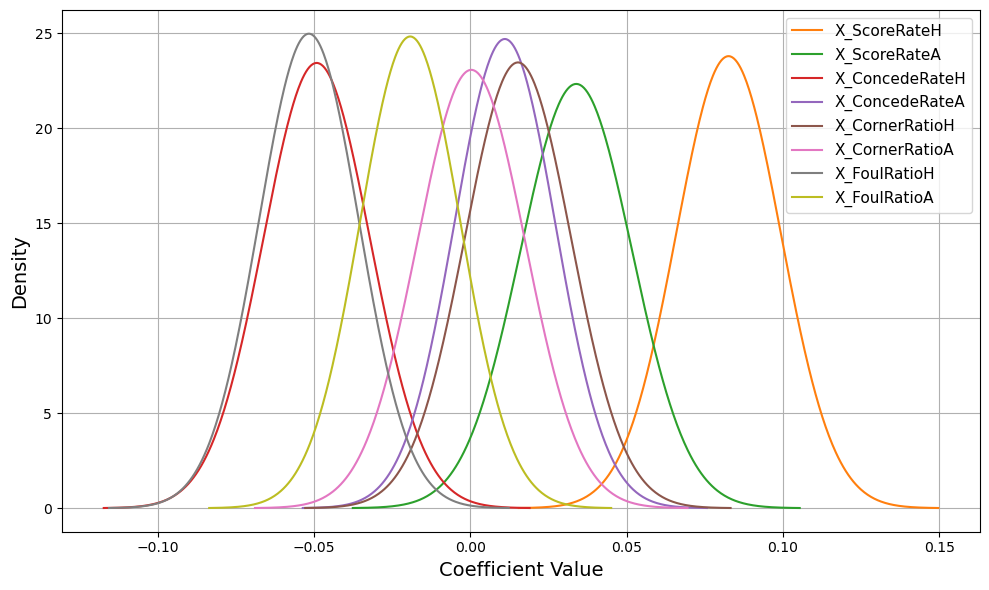

In [8]:
from scipy.stats import norm
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

colors  = sns.color_palette("tab10", betas.shape[0])

for i, (mean_i, color) in enumerate(zip(beta_mean, colors)):
    if i == 0: # skip the intercept again
        continue
    std_i = np.sqrt(Sigma[i, i])
    
    x = np.linspace(mean_i - 4 * std_i, mean_i + 4 * std_i, 500)
    plt.plot(x, norm.pdf(x, mean_i, std_i), label=labels[i], color=color)

    
plt.xlabel("Coefficient Value", fontsize=14)
plt.ylabel("Density", fontsize=14)
plt.legend( fontsize=11)
plt.grid(True)
plt.tight_layout()
plt.savefig("report/figures/approximation.png")

### Prediction for the test cases

In [9]:
# Prediction for the test cases 
X_test = df_test.drop(columns="GoalsScored").copy()

# Scale and add the column of ones for the intercept 
X_test = scaler.fit_transform(X_test)
X_test = np.hstack([np.ones((X_test.shape[0], 1)), X_test])

In [ ]:
from scipy.stats import mode

# Get the distributions 
n_samples = 1000
beta_distros =  np.random.multivariate_normal(beta_mean, Sigma, size=n_samples)
# make the predictions 
lambdas_distros = np.exp(X_test @ beta_distros.T) 
# samplat je treba pol se iz usake lambde npr 100krat
predictive_distros = np.random.poisson(lam=lambdas_distros[..., np.newaxis], 
                                       size=(*lambdas_distros.shape, n_samples))
# reshape the distros
predictive_distros = predictive_distros.reshape(100, 1000 * 1000)

# make point prediction
# squarred error - use the mean
sq_error_preds = np.mean(predictive_distros, axis=1)

# absolute error - use the median
abs_error_preds = np.median(predictive_distros, axis = 1)

# accuracy - use the mode
acc_error_preds = mode(predictive_distros, axis=1, keepdims=False)